In [717]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.optimize as sc
import plotly.graph_objects as go

In [718]:
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData["Close"]
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix


In [719]:
df = pd.read_csv("nportfolio.csv")
weights = np.array(df["Weight"])
stockList = df["Ticker"].tolist()

In [720]:
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=900)
startDate = "2015-01-01"

In [721]:
meanReturns, covMatrix = get_data(stockList, startDate, endDate)

[********              17%                       ]  3 of 18 completed

[*********************100%***********************]  18 of 18 completed


## Montecarlo Simulation Method

In [722]:
mc_sims = 1000
T = 252

meanM = np.full(shape=(T,len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 711233

for m in range(0,mc_sims):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights,dailyReturns.T)+1)*initialPortfolio




In [723]:
def mcVar(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """ 
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

In [724]:
def mcCVar(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVar or expected shortfall to a diven confidence level alpha
    """ 
    if isinstance(returns, pd.Series):
        belowVar = returns <= mcVar(returns, alpha= alpha)
        return returns[belowVar].mean()
    else:
        raise TypeError("Expected a pandas data series.")

VaR $104369.95
CVaR $175658.74


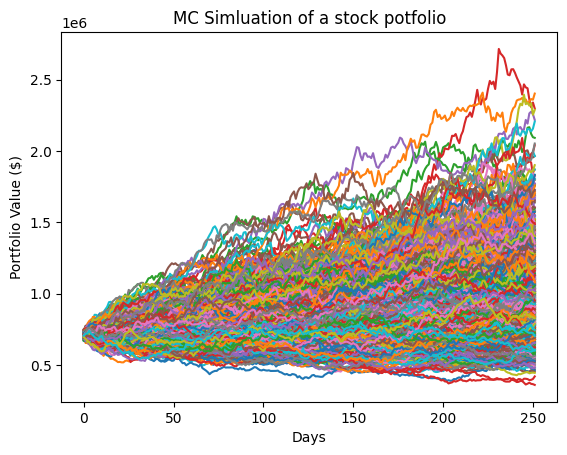

In [725]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVar(portResults, alpha=5)
CVaR = initialPortfolio - mcCVar(portResults, alpha=5)

print("VaR ${}".format(round(VaR,2)))
print("CVaR ${}".format(round(CVaR,2)))
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("MC Simluation of a stock potfolio")
plt.show()

In [748]:
expected_price = portfolio_sims[:,-1].mean()
print(expected_price)

968200.5194237116


In [726]:
def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(252)
    return returns, std


In [727]:
returns, std = portfolioPerformance(weights,meanReturns,covMatrix)

In [728]:
print(round(returns*100,2), round(std*100,2))

35.15 28.98


In [729]:
def negativeSR(weights, meanReturns, covMatrix, riskFree=0):
    preturns, pstd = portfolioPerformance(weights,meanReturns,covMatrix)
    return - (preturns - riskFree)/pstd

In [730]:
def maxSR(meanReturns, covMatrix, riskFree=0, constrainSet=(0,3)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFree)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = constrainSet
    bounds = tuple(bound for assets in range(numAssets))
    results = sc.minimize(negativeSR, numAssets*[1./numAssets], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return results


In [731]:
result = maxSR(meanReturns,covMatrix)
newweights = result.x
print(result)

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -1.4643152775214192
           x: [ 0.000e+00  0.000e+00 ...  0.000e+00  4.139e-02]
         nit: 11
         jac: [ 2.952e-02  3.181e-01 ...  3.440e-01  2.429e-04]
        nfev: 212
        njev: 11
 multipliers: [ 4.387e-05]


In [732]:
nreturns, nstd = portfolioPerformance(newweights,meanReturns,covMatrix)

In [733]:
print(round(nreturns*100,2), round(nstd*100,2))

43.85 29.95


In [734]:
mc_sims = 1000
T = 365

meanM = np.full(shape=(T,len(newweights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 711233

for m in range(0,mc_sims):
    Z = np.random.normal(size=(T, len(newweights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(newweights,dailyReturns.T)+1)*initialPortfolio

VaR $38194.2
CVaR $133330.66


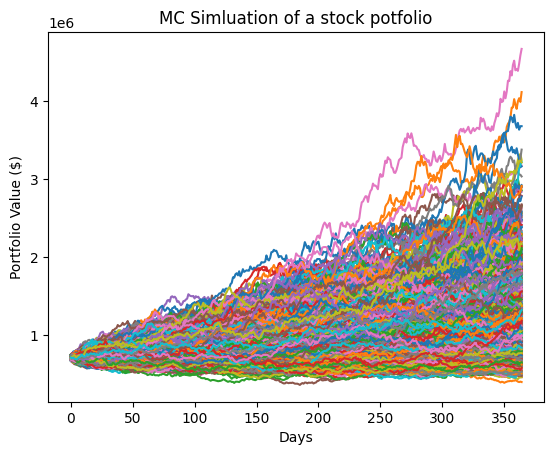

In [735]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVar(portResults, alpha=5)
CVaR = initialPortfolio - mcCVar(portResults, alpha=5)

print("VaR ${}".format(round(VaR,2)))
print("CVaR ${}".format(round(CVaR,2)))
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("MC Simluation of a stock potfolio")
plt.show()

In [736]:
def portfolioVariance(weights,meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]

In [737]:
def minimizeVariance(meanReturns, covMatrix, constrainSet=(0,3)):
    "Minimize portfolio variance by altering weights"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = constrainSet
    bounds = tuple(bound for assets in range(numAssets))
    results = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return results

In [738]:
minVarResult = minimizeVariance(meanReturns,covMatrix)
minVar, minVarWeights = minVarResult["fun"],minVarResult["x"]
print(minVar, minVarWeights)

0.17918218378202844 [2.04634811e-02 1.72829807e-18 1.56497801e-02 1.37892835e-02
 4.44724373e-02 1.48591602e-01 7.02010873e-02 3.42667673e-01
 3.89557782e-18 3.13117638e-02 0.00000000e+00 1.89117779e-17
 7.00587340e-03 0.00000000e+00 0.00000000e+00 8.05103095e-02
 8.61940727e-18 2.25336709e-01]


In [739]:
mreturns, mstd = portfolioPerformance(minVarWeights,meanReturns,covMatrix)

print(round(mreturns*100,2), round(mstd*100,2))

16.75 17.92


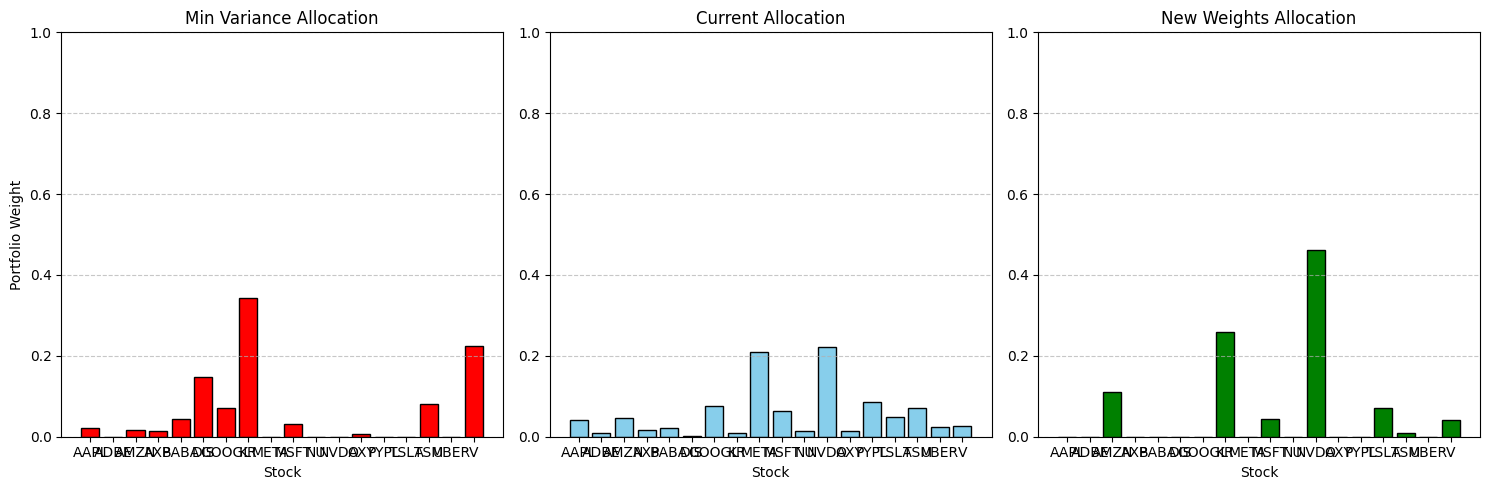

In [740]:
df = pd.DataFrame()
df["stock"] = stockList
df["neww"] = newweights
df["w"] = weights
df["minVarweights"] = minVarWeights

# Example: three portfolio allocations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axes[0].bar(df["stock"], df["minVarweights"], color='red', edgecolor='black')
axes[0].set_title("Min Variance Allocation")
axes[0].set_xlabel("Stock")
axes[0].set_ylabel("Portfolio Weight")
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot
axes[1].bar(df["stock"], df["w"], color='skyblue', edgecolor='black')
axes[1].set_title("Current Allocation")
axes[1].set_xlabel("Stock")
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Third subplot
axes[2].bar(df["stock"], df["neww"], color='green', edgecolor='black')
axes[2].set_title("New Weights Allocation")
axes[2].set_xlabel("Stock")
axes[2].set_ylim(0, 1)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Efficient Frontier:

# Calculating the Efficient frontier

In [741]:
def portfolioReturn(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]

def efficientOptim(meanReturns, covMatrix, returnTarget,constraintSet=(0,3)):
    " For each returnTarget we want to optimize the portfolio por minVariance"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)

    constraints = ({"type": "eq", "fun": lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                    {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    effopt = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args,constraints=constraints, bounds=bounds, method="SLSQP")
    
    return effopt

In [742]:
print(efficientOptim(meanReturns, covMatrix, 0.3))

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.21706126368635098
           x: [ 1.126e-02  2.304e-17 ...  0.000e+00  1.924e-01]
         nit: 10
         jac: [ 1.944e-01  2.206e-01 ...  2.516e-01  1.666e-01]
        nfev: 191
        njev: 10
 multipliers: [ 4.750e-01  7.457e-02]


In [743]:
def calculatedResults(meanReturns, covMatrix, riskFree=0.08, constraintSet=(0,3)):

    # Max SR Portfolio
    maxSR_Portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio["x"],meanReturns,covMatrix)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio["x"],index=meanReturns.index,columns=["allocation"])
    

    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio["x"],meanReturns,covMatrix)
    minVol_allocation = pd.DataFrame(maxSR_Portfolio["x"],index=meanReturns.index,columns=["allocation"])
    

    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns: 
        efficientList.append(efficientOptim(meanReturns, covMatrix, target)["fun"])

    maxSR_allocation.allocation = [round(i*100,2) for i in maxSR_allocation.allocation]
    minVol_allocation.allocation = [round(i*100,2) for i in minVol_allocation.allocation]

    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns

In [744]:
maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix)
print(maxSR_returns, maxSR_std, minVol_returns, minVol_std, efficientList, targetReturns)

0.4385237611896711 0.29947359555787784 0.16745044283719593 0.17918218378202844 [np.float64(0.17918183414896496), np.float64(0.1798405228267202), np.float64(0.18181662256622785), np.float64(0.18489957699162363), np.float64(0.18852944357899631), np.float64(0.19269099378166984), np.float64(0.19745688243154513), np.float64(0.20281134261696615), np.float64(0.208709006055585), np.float64(0.21511066314846922), np.float64(0.22198324148129703), np.float64(0.22928912371935034), np.float64(0.236994929168215), np.float64(0.2450677044539504), np.float64(0.2534734367780108), np.float64(0.26218010625902566), np.float64(0.27115739983017023), np.float64(0.28038102537133536), np.float64(0.2898269479701848), np.float64(0.2994738476857273)] [0.16745044 0.18171746 0.19598448 0.21025149 0.22451851 0.23878553
 0.25305254 0.26731956 0.28158658 0.29585359 0.31012061 0.32438763
 0.33865464 0.35292166 0.36718868 0.38145569 0.39572271 0.40998973
 0.42425674 0.43852376]


In [745]:
def EF_graph(meanReturns, covMatrix, riskFree=0.08, constraintSet=(0,3)):
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix)

    # Max SR
    MaxSR = go.Scatter(
        name="Maximum Sharpe Ratio",
        mode="markers",
        x=[round(maxSR_std*100,2)],
        y=[round(maxSR_returns*100,2)],
        marker=dict(color="red",size=14,line=dict(width=3, color='black'))
    )

    #Min Vol
    MinVol = go.Scatter(
        name="Minimum  Volatility",
        mode="markers",
        x=[round(minVol_std*100,2)],
        y=[round(minVol_returns*100,2)],
        marker=dict(color="green",size=14,line=dict(width=3, color='black'))
    )

    #Efficient Frontier
    EFF = go.Scatter(
        name="Efficient Frontier",
        mode="lines",
        x=[round(ef_std*100,2) for ef_std in efficientList],
        y=[round(target*100,2) for target in targetReturns],
        line=dict(color="black", width=4, dash="dashdot")
    )

    data = [MaxSR, MinVol, EFF]

    layout = go.Layout(
        title="Portfolio Optimization with the Efficient Frontier",
        yaxis=dict(title="Annualized return (%)"),
        xaxis=dict(title="Annualized Volatility (%)"),
        showlegend=True,
        legend=dict(
            x=0.75, y=0, traceorder="normal",
            bgcolor="#E2E2E2",
            bordercolor = "black",
            borderwidth=2),
        width=800,
        height=600)
    
    fig = go.Figure(data=data, layout=layout)
    return fig.show()

In [746]:
EF_graph(meanReturns, covMatrix)